<a href="https://colab.research.google.com/github/SHodapp117/Applied-Machine-Learning/blob/main/Decision_Tree_%26_SVM_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'dapperlabs-data' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=dapperlabs-data:US:bquxjob_587dcd4b_18c11ab5926)
back to BigQuery to edit the query within the BigQuery user interface.

In [ ]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_587dcd4b_18c11ab5926') # Job ID inserted based on the query results selected to explore
print(job.query)

WITH listing_history as (
  select *
  from `dapperlabs-data.berkeley_ds_sandbox.berkeley_ds_source_nfl_historical_listings_time_series`
),
-- get unique rows for every week in last 6m per moment
weekly_series as (
    select distinct a.flow_moment_id, a.moment_flow_edition_id, date_trunc(date, week) as week
    from listing_history as a,
        unnest(generate_date_array(date_trunc(date_sub(date_trunc(current_date, month), interval 6 month), week), date_sub(date_trunc(current_date(), week), interval 3 week), interval 1 day)) as date
),
--- weekly avg of sold listings
sold_avg AS (
  SELECT w.week, w.flow_moment_id, w.moment_flow_edition_id, AVG(l.listing_price_usd) AS avg_sold
  FROM weekly_series as w
  LEFT JOIN (select * from listing_history where listing_status = 'SOLD')  as l
    on w.flow_moment_id = l.flow_moment_id
      and date_trunc(l.event_timestamp, week) = w.week
  GROUP BY w.week, w.flow_moment_id, w.moment_flow_edition_id
),
-- weekly avg of non sold listings
listed_a

# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [ ]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_587dcd4b_18c11ab5926') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
df = results

## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [ ]:
df.head()

,week,flow_moment_id,moment_flow_edition_id,avg_sold,avg_listed,edition_floor_listed,median_edition_listing_price,moment_value_current_week,target_moment_value_next_week,Common,...,position_QB,position_RB,position_WR,position_TE,position_LB,position_DL,position_DB,rarity,serial_to_mint_ratio,listed_supply
0,2023-04-30,1000002,547,NaN,10000.0,109.0,130.0,130.0,109.0,0,...,0,0,0,1,0,0,0,0.009174,0.347052,57
1,2023-04-30,1000002,547,NaN,10000.0,109.0,130.0,130.0,109.0,0,...,0,0,0,1,0,0,0,0.009174,0.347052,57
2,2023-04-30,1000002,547,NaN,10000.0,109.0,NaN,109.0,122.0,0,...,0,0,0,1,0,0,0,0.009174,0.347052,58
3,2023-04-30,1000002,547,NaN,10000.0,109.0,130.0,130.0,109.0,0,...,0,0,0,1,0,0,0,0.009174,0.347052,64
4,2023-04-30,1000002,547,NaN,10000.0,109.0,130.0,130.0,109.0,0,...,0,0,0,1,0,0,0,0.009174,0.347052,67


<Axes: xlabel='moment_value_current_week', ylabel='avg_listed'>

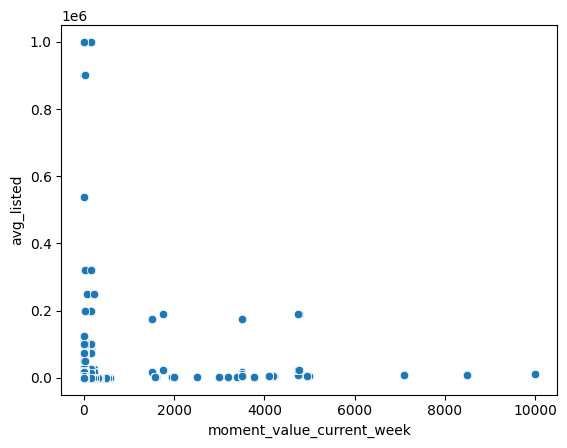

In [ ]:
import seaborn as sns
sns.scatterplot(data=df, x='moment_value_current_week', y='avg_listed')

In [ ]:
numerical_features = ['final_player_score', 'serial_to_mint_ratio', 'listed_supply', 'avg_sold', 'avg_listed', 'moment_value_current_week','rarity']
df.describe()

,avg_sold,avg_listed,edition_floor_listed,median_edition_listing_price,moment_value_current_week,target_moment_value_next_week,Common,Rare,Legendary,Ultimate,position_QB,position_RB,position_WR,position_TE,position_LB,position_DL,position_DB,rarity,serial_to_mint_ratio,listed_supply
count,74538.000000,835908.000000,2.000000e+06,1.102478e+06,2.000000e+06,2.000000e+06,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0,2.000000e+06,2.000000e+06,2000000.0
mean,7.464143,1556.517619,6.628316e+00,3.022988e+01,1.225963e+01,1.236354e+01,0.977573,0.020418,0.002009,0.0,0.036367,0.17427,0.385769,0.204303,0.069823,0.010198,0.038376,8.879464e-01,4.700240e-01,418.2364
std,51.368321,26615.576312,7.552999e+01,2.127530e+02,1.433685e+02,1.337160e+02,0.148068,0.141425,0.044777,0.0,0.187202,0.379342,0.486777,0.403191,0.254849,0.100471,0.192102,2.758058e-01,3.006244e-01,91.333763
min,1.000000,2.000000,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.714286e-04,1.000000e-04,10.0
25%,2.000000,8.000000,1.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,1.968000e-01,356.0
50%,3.000000,17.000000,1.000000e+00,9.500000e+00,1.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,4.646000e-01,434.0
75%,3.000000,48.000000,1.000000e+00,1.300000e+01,5.000000e+00,6.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000e+00,7.311000e-01,488.0
max,1500.000000,1000000.000000,1.750000e+03,4.774500e+03,9.999000e+03,4.824500e+03,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,598.0


In [ ]:
# Count the number of missing values in each column of the DataFrame
missing_values_count = df.isna().sum()

# Print the counts
print("Missing values in each column:")
print(missing_values_count)

Missing values in each column:
week                                   0
flow_moment_id                         0
moment_flow_edition_id                 0
avg_sold                         1925462
avg_listed                       1164092
edition_floor_listed                   0
median_edition_listing_price      897522
moment_value_current_week              0
target_moment_value_next_week          0
Common                                 0
Rare                                   0
Legendary                              0
Ultimate                               0
position_QB                            0
position_RB                            0
position_WR                            0
position_TE                            0
position_LB                            0
position_DL                            0
position_DB                            0
rarity                                 0
serial_to_mint_ratio                   0
listed_supply                          0
dtype: int64


In [ ]:
# In the SQL we buil the decision logic to fill out moment current value next week, as the prime mover. We can therfore replace avg_sold, avg_listed and median edition listing with zeros, as the important information is caputred
import numpy as np
import pandas as pd
df = df.fillna(0)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

df[['avg_sold',
       'avg_listed', 'edition_floor_listed', 'median_edition_listing_price',
       'moment_value_current_week', 'target_moment_value_next_week', 'listed_supply']] = mms.fit_transform(df[['avg_sold',
       'avg_listed', 'edition_floor_listed', 'median_edition_listing_price',
       'moment_value_current_week', 'target_moment_value_next_week', 'listed_supply']])

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

df.sort_values(by='week', ascending=True)

tss = TimeSeriesSplit(n_splits=5)

df.set_index('week', inplace=True)

X = df.drop(labels=['target_moment_value_next_week'], axis=1)
y = df['target_moment_value_next_week']

# Lists to store MSE for each fold
mse_list = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the LinearSVR model
    svr = LinearSVR()
    svr.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svr.predict(X_test)

    # Calculate mean squared error for evaluation
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

# Print the mean squared error for each fold
print("Mean Squared Error for each fold:", mse_list)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Squared Error for each fold: [4.118297021372087e-05, 0.007937027579420412, 0.0040710133231630224, 0.0001634179067277639, 1.009254492897528e-05]


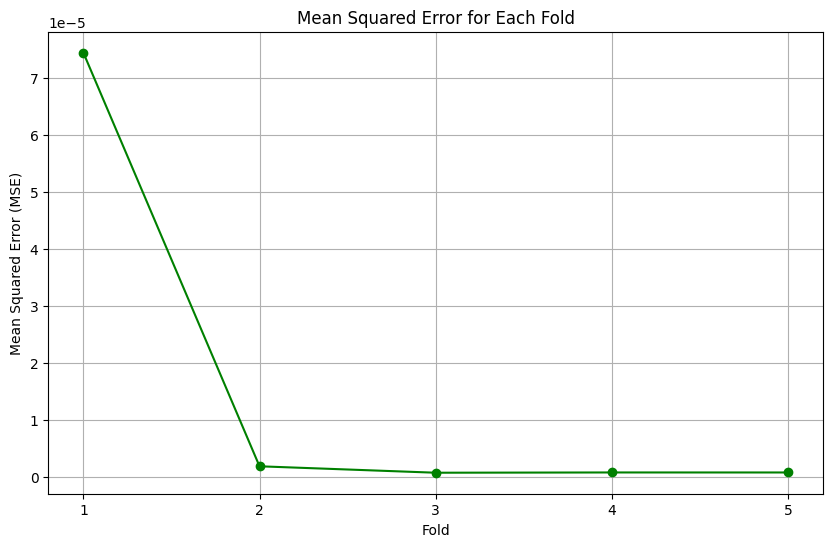

In [ ]:
import matplotlib.pyplot as plt
# Plot the MSE values for each fold as a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='green', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error for Each Fold')
plt.xticks(range(1, len(mse_list) + 1))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Lists to store MSE for each fold
mse_list_regr = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the DecisionTreeRegressor model
    regr = DecisionTreeRegressor(max_depth = 3)
    model = regr.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate mean squared error for evaluation
    mse_regr = mean_squared_error(y_test, y_pred)
    mse_list.append(mse_regr)

# Print the mean squared error for each fold
print("Mean Squared Error for each fold:", mse_list_regr)


Mean Squared Error for each fold: []


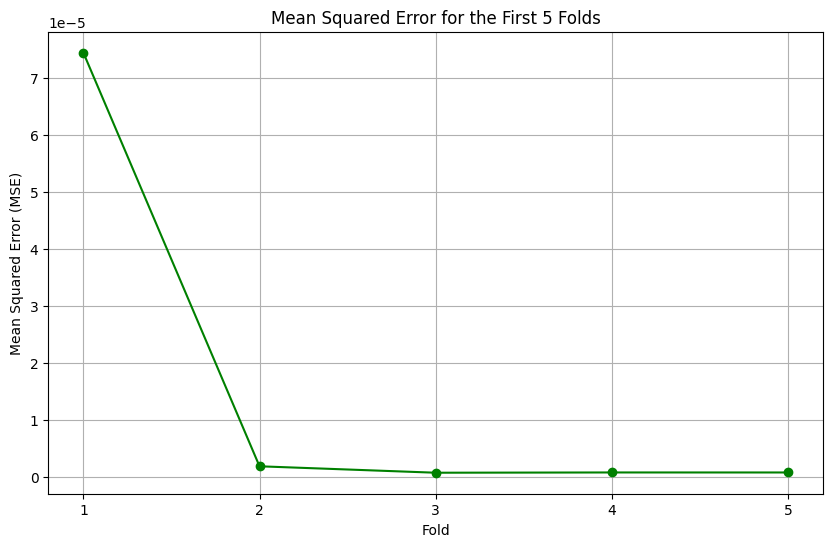

In [ ]:
import matplotlib.pyplot as plt

# Assuming mse_list is already calculated

# Plot the MSE values for the first 5 folds as a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), mse_list[:5], marker='o', color='green', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error for the First 5 Folds')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()


In [ ]:
from sklearn import tree
text_representation = tree.export_text(regr)
print(text_representation)


|--- feature_9 <= 0.50
|   |--- feature_8 <= 0.50
|   |   |--- feature_18 <= 0.20
|   |   |   |--- value: [0.01]
|   |   |--- feature_18 >  0.20
|   |   |   |--- value: [0.00]
|   |--- feature_8 >  0.50
|   |   |--- feature_3 <= 0.00
|   |   |   |--- value: [0.02]
|   |   |--- feature_3 >  0.00
|   |   |   |--- value: [0.04]
|--- feature_9 >  0.50
|   |--- feature_3 <= 0.00
|   |   |--- feature_6 <= 0.18
|   |   |   |--- value: [0.34]
|   |   |--- feature_6 >  0.18
|   |   |   |--- value: [0.43]
|   |--- feature_3 >  0.00
|   |   |--- feature_6 <= 0.39
|   |   |   |--- value: [0.72]
|   |   |--- feature_6 >  0.39
|   |   |   |--- value: [0.90]



Text(0.5, 1.0, 'Decision Tree with Feature Names for NFL All Day Moments')

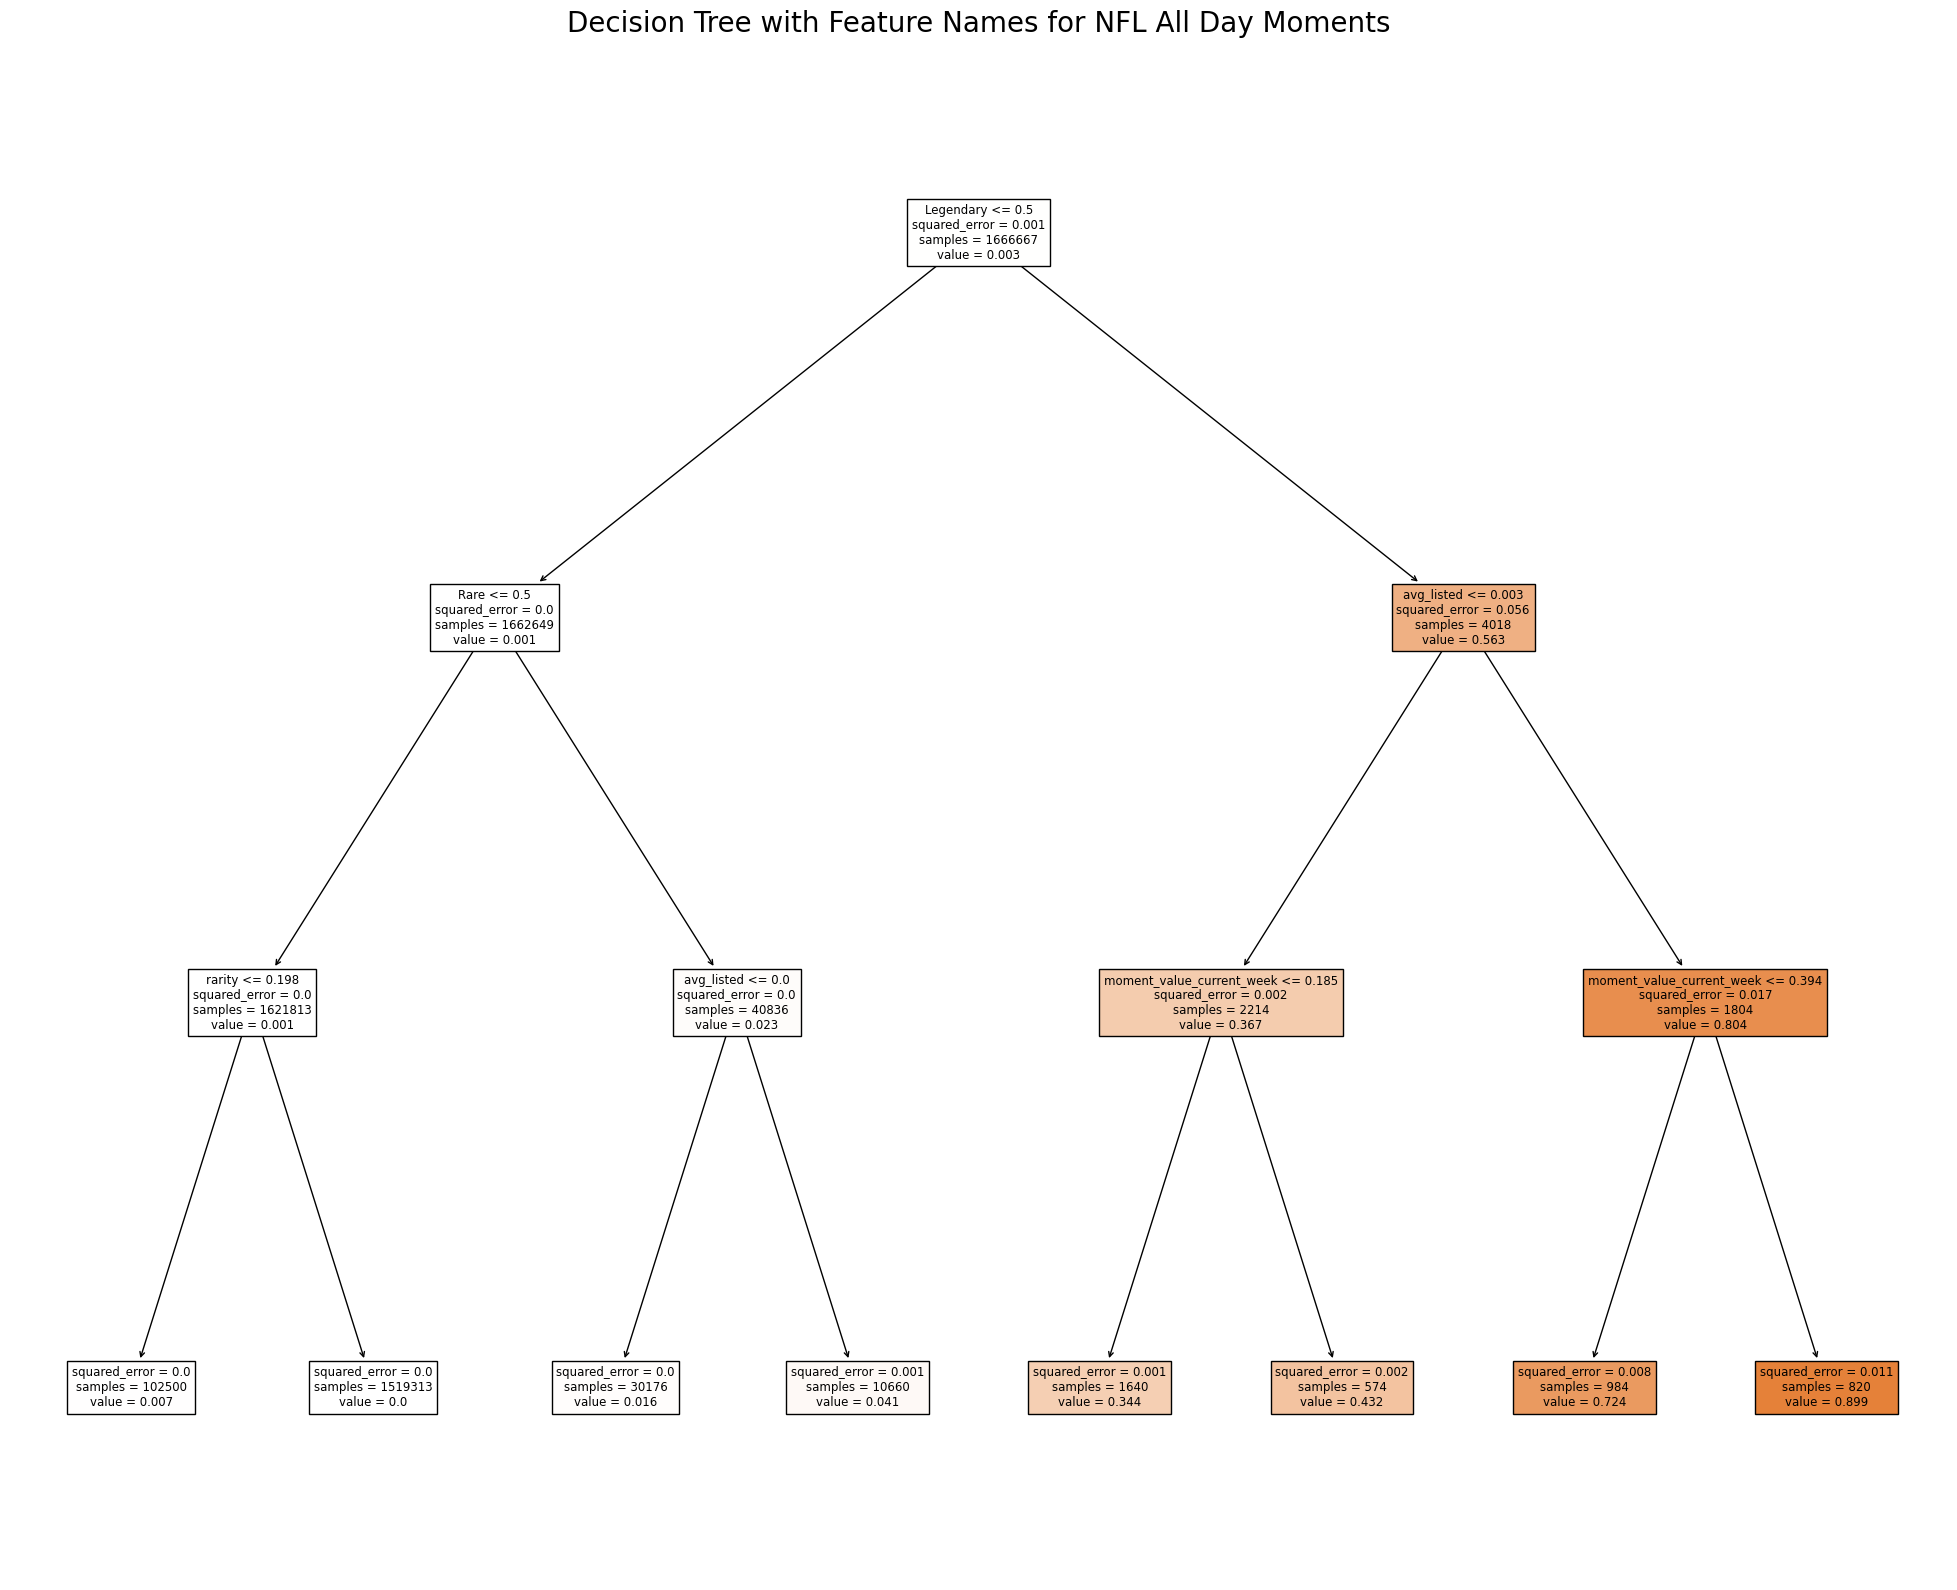

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=X.columns, filled=True)
plt.title("Decision Tree with Feature Names for NFL All Day Moments", fontsize=20)

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Assuming X, y are your features and target variable
# Assuming model is your trained model

# Evaluation metrics
metrics = {
    'Mean Squared Error (MSE)': mean_squared_error,
    'R-squared (R²)': r2_score,
    'Mean Absolute Error (MAE)': mean_absolute_error
}

# Cross-validated metrics
cv_metrics = {
    'Cross-Validation MSE': 'neg_mean_squared_error',
    # Add other metrics as needed
}

# Calculate metrics
results = {}
for metric_name, metric_func in metrics.items():
    y_pred = model.predict(X)
    results[metric_name] = metric_func(y, y_pred)

for metric_name, scoring in cv_metrics.items():
    cv_score = cross_val_score(model, X, y, cv=5, scoring=scoring)
    results[metric_name] = cv_score.mean()

# Create a DataFrame
metrics_df = pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])
print(metrics_df)


                      Metric     Value
0   Mean Squared Error (MSE)  0.000019
1             R-squared (R²)  0.975769
2  Mean Absolute Error (MAE)  0.001100
3       Cross-Validation MSE -0.000746


In [ ]:
from tabulate import tabulate

# Assuming metrics_df is your DataFrame
table_str = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)
print(table_str)


+---------------------------+------------------------+
|          Metric           |         Value          |
+---------------------------+------------------------+
| Mean Squared Error (MSE)  | 1.8621756300320622e-05 |
|      R-squared (R²)       |   0.975768601574471    |
| Mean Absolute Error (MAE) | 0.0010998305482515845  |
|   Cross-Validation MSE    |  -0.00074624719690421  |
+---------------------------+------------------------+


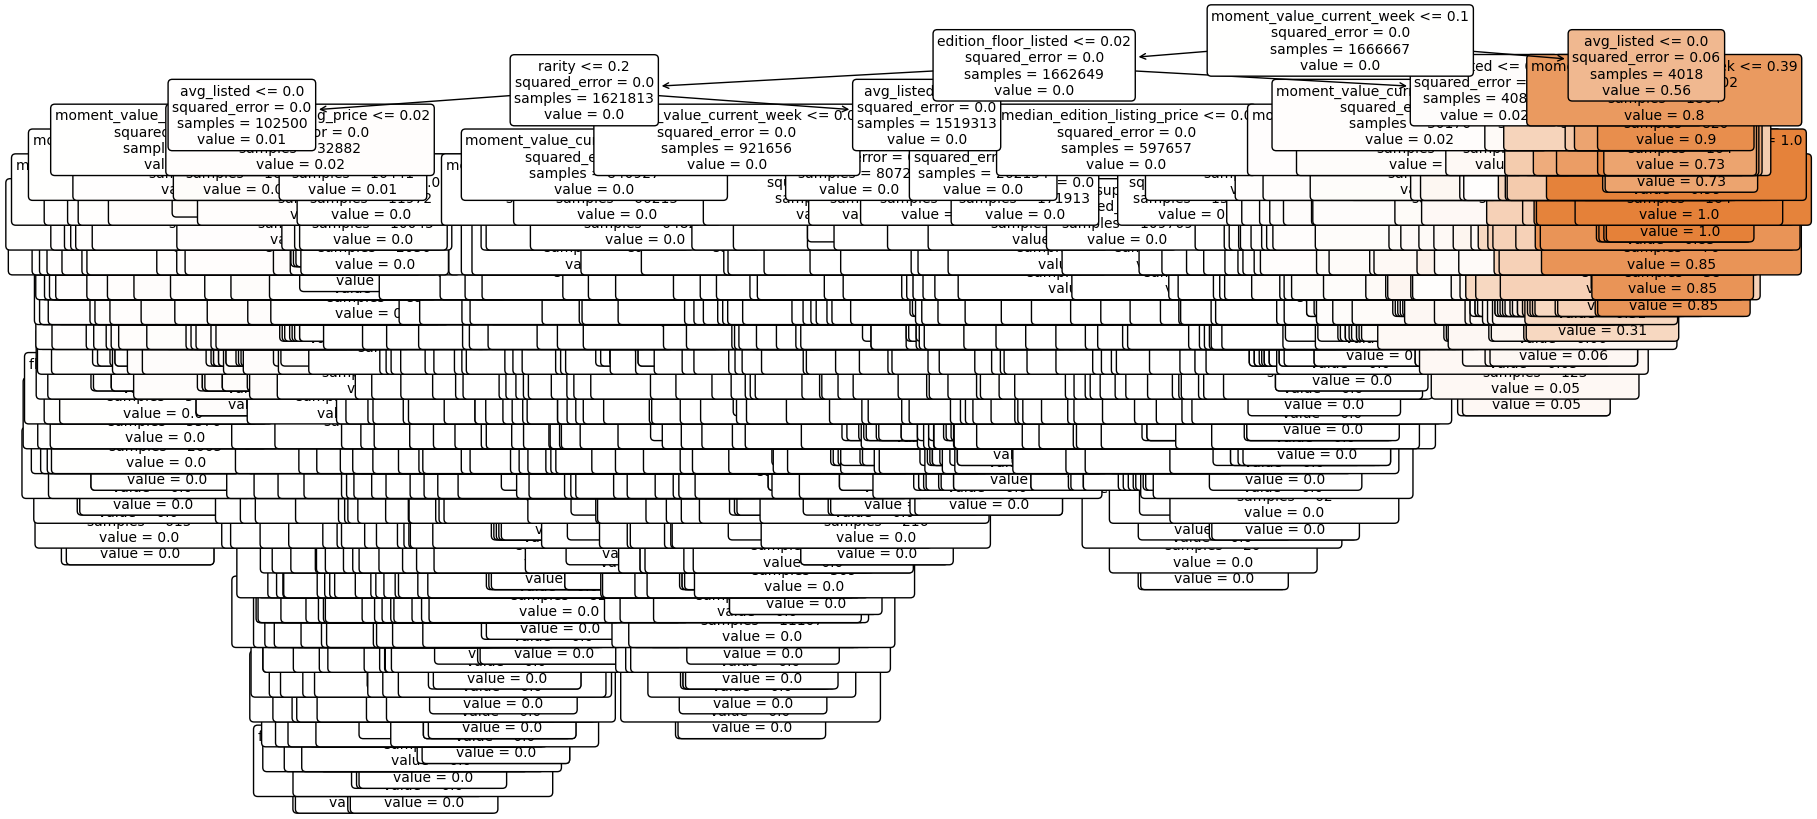

In [ ]:
from sklearn.tree import plot_tree

# Create and train the DecisionTreeRegressor model
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

# Calculate mean squared error for evaluation
mse = mean_squared_error(y_test, y_pred)

# Visualize the Decision Tree with nodes where the value is higher than 0.1
plt.figure(figsize=(20, 10))

# Create a mask to filter nodes based on their values
mask = dtree.tree_.value[:, 0, 0] > 0.1

# Plot the tree with the mask
plot_tree(dtree, filled=True, feature_names=X.columns, rounded=True, fontsize=10, precision=2)

# Show the plot
plt.show()


In [ ]:
# Save the figure as a 400x315 PNG image
fig.savefig("decision_tree.png", dpi=100, bbox_inches="tight")

In [ ]:

# Access feature importances
feature_importances = dtree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)

                         Feature    Importance
6      moment_value_current_week  8.328939e-01
3                     avg_listed  1.418429e-01
4           edition_floor_listed  1.376039e-02
18                        rarity  7.274061e-03
5   median_edition_listing_price  2.529727e-03
0                 flow_moment_id  1.115332e-03
19          serial_to_mint_ratio  4.523891e-04
13                   position_WR  3.243334e-05
1         moment_flow_edition_id  3.123413e-05
20                 listed_supply  3.001847e-05
14                   position_TE  2.649627e-05
2                       avg_sold  5.674609e-06
11                   position_QB  3.011387e-06
12                   position_RB  2.236460e-06
17                   position_DB  2.090412e-07
15                   position_LB  9.164908e-09
16                   position_DL  4.590909e-09
9                      Legendary  0.000000e+00
8                           Rare  0.000000e+00
7                         Common  0.000000e+00
10           

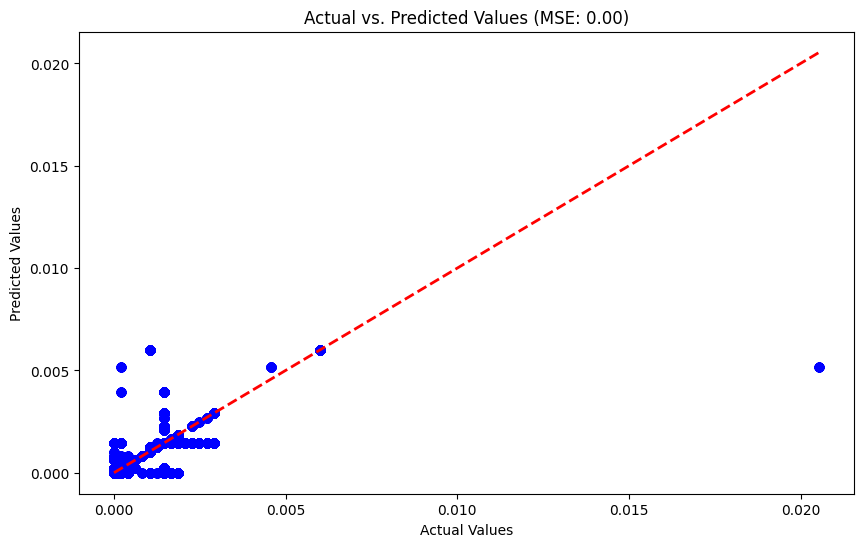

Mean Squared Error for each fold: [7.436638472663464e-05, 1.8515484710406444e-06, 7.234651597449418e-07, 7.70171275876793e-07, 7.667170001198482e-07]


In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (MSE: {:.2f})'.format(mse))
plt.show()

# Print the mean squared error for each fold
print("Mean Squared Error for each fold:", mse_list)